In [2]:
import pybullet as p
import numpy as np
import json
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
import time

sys.path.append("../")
from env.ycb_scene import SimulatedYCBEnv
from utils.utils import *
from utils.planner import GraspPlanner

pybullet build time: Nov 28 2023 23:51:11


In [3]:
'''
get data file name in json file and load mesh in pybullet
then reset robot and object position
'''

file = os.path.join("../object_index", 'contact_plane_object.json')   # 此json檔可以自己改
with open(file) as f: file_dir = json.load(f)
file_dir = file_dir['tomato']     #只取json檔中的"test"
file_dir = [f[:-5] for f in file_dir]
test_file_dir = list(set(file_dir))

env = SimulatedYCBEnv()
env._load_index_objs(test_file_dir)      #597

#ycb scene 中的 init 可以定義target_fixed, true代表target object不會自由落下 (第一次呼叫cabinet設定即可)
state = env.different_cabinet(save=False, enforce_face_target=True)  

startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1080 Ti/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1080 Ti/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
numActiveThreads = 0
stopping threads
destroy semaphore
semaphore destroyed
Thread with taskId 0 exiting
Thread TERMINATED
destroy main semaphore
main semaphore destroye

In [4]:
num_object = 1
placed_obj = {}   # define a dictionary
print(env.placed_objects)

placed_idx = np.where(np.array(env.placed_objects))[0]   # np.where有兩種用法, 一種為condition, 一種為此的用法
print(placed_idx)
# print(env.obj_indexes)   # all object name in dict
placed_name = np.array(env.obj_indexes)[placed_idx]
for i in range(num_object):
    placed_obj[placed_idx[i]] = placed_name[i]
print(placed_obj)    # only on table obj name
print(placed_name[0])

[True, False, False]
[0]
{0: '005_tomato_soup_can_1.0'}
005_tomato_soup_can_1.0


In [5]:
env.draw_ef_coordinate(env._get_ef_pose(mat=True)@ env._get_target_relative_pose(option = 'ef'), 0)
env.draw_ef_coordinate(env._get_ef_pose(mat=True), 0)

In [6]:
env.clean_debug_line()

In [7]:
from utils.planner import GraspPlanner
planner = GraspPlanner()

def expert_plan(goal_pose, world=False, visual=False):
    if world:
        pos, orn = env._get_ef_pose()
        ef_pose_list = [*pos, *orn]
    else:
        ef_pose_list = [0, 0, 0, 0, 0, 0, 1]
    goal_pos = [*goal_pose[:3], *ros_quat(goal_pose[3:])]

    solver = planner.plan(ef_pose_list, goal_pos)
    if visual:
        path_visulization(solver)
    path = solver.getSolutionPath().getStates()
    planer_path = []
    for i in range(len(path)):
        waypoint = path[i]
        rot = waypoint.rotation()
        action = [waypoint.getX(), waypoint.getY(), waypoint.getZ(), rot.w, rot.x, rot.y, rot.z]
        planer_path.append(action)

    return planer_path

def path_visulization(ss):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    x = []
    y = []
    z = []
    for i in range(len(ss.getSolutionPath().getStates())):
        state = ss.getSolutionPath().getStates()[i]
        x.append(state.getX())
        y.append(state.getY())
        z.append(state.getZ())
    ax.plot(x, y, z, color='gray', label='Curve')

    ax.scatter(x, y, z, c=z, cmap='jet', label='Points')
    plt.show()
def execute_motion_plan(env, plan, execute=False, gripper_set="close", repeat=100):
    """
    Executes a series of movements in a robot environment based on the provided plan.

    Parameters:
    - env: The current robot environment, providing inverse kinematics solving and stepping capabilities.
    - plan: A plan containing target positions, each position is a list with coordinates and orientation.
    - execute: A boolean indicating whether to execute the actions. If False, only resets the robot's joint positions without stepping through the environment.
    """

    '''
    plan中的每一個step都會做碰撞檢查, 如果有碰撞就會停止並回傳flase
    '''
    for i in range(len(plan)):
        # Set target position using world frame based coordinates
        next_pos = plan[i]
        jointPoses = env._panda.solveInverseKinematics(next_pos[:3], ros_quat(next_pos[3:]))
        if gripper_set == "close":
            jointPoses[6] = 0.85
        else:
            jointPoses[6] = 0.0
        jointPoses = jointPoses[:7].copy()  # Consider only the first 7 joint positions
                
        if execute:
            # Execute the action and obtain the observation
            obs = env.step(jointPoses, config=True, repeat=repeat)[0]
            # print("JointPoses = ", jointPoses)
        else:
            # Only reset the robot's joint positions
            env._panda.reset(joints=jointPoses)
            # 在path length中每一步都檢查是否會發生碰撞
            if(env._panda.check_for_collisions() == True):
                print("Collision detected in the path")
                return False
    return True

In [8]:
# 角度轉徑度
def deg2rad(deg):
    return deg * np.pi / 180

mid_retract_pose = rotZ(-np.pi/2)@ transZ(0.65)@ transX(0.3)@ transY(0.3)@ np.eye(4)@ rotZ(np.pi/4*3)@ rotX(np.pi/4*3)

env_pose = np.eye(4)
#對z增加高度
env_pose[0, 3] = 0.2
env_pose[1, 3] = -0.1
env_pose[2, 3] = 0.6
#對z轉90度再對x轉100度
env_pose = env_pose @ rotZ(deg2rad(90)) @ rotX(deg2rad(110))



Debug:   RRTstar: Planner range detected to be 7.242362
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 0.74 in 50 iterations (51 vertices in the graph)
Interpolate Path length to 20Info:    RRTstar: Created 1048 new states. Checked 549676 rewire options. 1 goal states in tree. Final solution cost 0.738



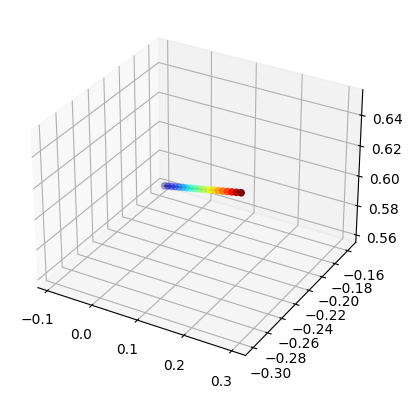

Debug:   RRTstar: Planner range detected to be 7.242362
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 1.05 in 84 iterations (85 vertices in the graph)
Interpolate Path length to 20Info:    RRTstar: Created 1036 new states. Checked 537166 rewire options. 1 goal states in tree. Final solution cost 1.048



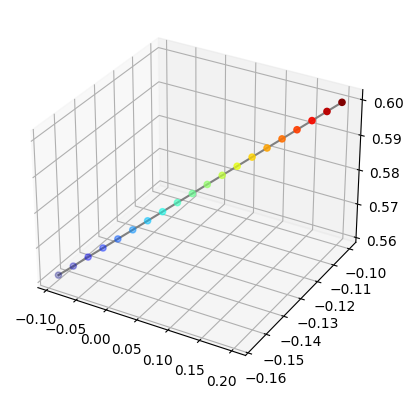

True

In [9]:
env._panda.reset()
END_POINT = mid_retract_pose
plan = expert_plan(pack_pose(END_POINT), world=True, visual=True)
END_POINT = env_pose
# env.draw_ef_coordinate(env._get_ef_pose(mat=True), 0)
plan = expert_plan(pack_pose(END_POINT), world=True, visual=True)
execute_motion_plan(env, plan, execute=False, gripper_set="open", repeat=200)

In [10]:
env.draw_ef_coordinate(env._get_ef_pose(mat=True), 0)
print(env._get_ef_pose(mat=True))
environment_ef_pose = env._get_ef_pose(mat=True)
cam_offset = np.eye(4)
# 先轉到pybullet座標後再往上移動0.13變相機座標
cam_offset[:3, 3] = (np.array([0., 0.1186, -0.0191344123493]))
# open3d 和 pybullet中的coordinate要對z旋轉180度才會一樣
cam_offset[:3, :3] = np.array([[-1, 0, 0],
                                [0, -1, 0],
                                [0, 0, 1]])
camera_2_world = cam_offset@ np.linalg.inv(environment_ef_pose)
base_y = -camera_2_world[:3, 0]
base_y = base_y / np.linalg.norm(base_y)

[[ 1.26273974e-03  3.41837040e-01  9.39758396e-01  1.91978827e-01]
 [ 9.99999117e-01 -4.33084220e-05 -1.32793089e-03 -8.92321393e-02]
 [-4.13236511e-04  9.39759244e-01 -3.41836793e-01  6.00049317e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [11]:
from  utils.placement_utils import  extract_point_clouds
parent_directory = os.path.dirname(os.getcwd()) 
print(parent_directory)
pcd_path = os.path.join(parent_directory, 'example_henry/pcd_data/environment_raw.pcd')

obs, _, _, _, _ = env._get_observation()
intrinsic_matrix = np.array([[320, 0, 320],
                            [0, 320, 320],
                            [0, 0, 1]])
color = obs[1][:3].T
depth = obs[1][3].T
environment_pc_full, environment_pc_segments, environment_pc_colors = extract_point_clouds(depth = depth,   K = intrinsic_matrix, rgb = color, z_range = [0.2, 1.])
environment_pcd = o3d.geometry.PointCloud()
environment_pcd.points = o3d.utility.Vector3dVector(environment_pc_full)
environment_pcd.colors = o3d.utility.Vector3dVector(environment_pc_colors)
environment_pcd.transform(np.linalg.inv(camera_2_world))
origin_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2, origin=[0, 0, 0])

o3d.visualization.draw_geometries([environment_pcd, origin_frame])
o3d.io.write_point_cloud(pcd_path, environment_pcd)

/home/user/henry_pybullet_ws/src/pybullet_ros


True

## start detect plane

In [11]:
from  utils.placement_utils import whole_pipe_realworld , whole_pipe_virtual
count = 0
total_count = 1
result_list = []
parent_directory = os.path.dirname(os.getcwd()) 
pcd_path = os.path.join(parent_directory, 'example_henry/pcd_data/environment_raw.pcd')
# pcd_path = os.path.join(parent_directory, 'example_henry/pcd_data/mid_shelf.pcd')

while count < total_count:
    # criterion, filtered_point_cloud, unit_vec = whole_pipe_virtual(pcd_path, min_ratio=0.05, threshold=0.02, iterations=2000, min_cluster = 5000, max_cluster = 70000)
    criterion, filtered_point_cloud, unit_vec = whole_pipe_realworld(pcd_path, min_ratio=0.05, threshold=0.02, iterations=2000, min_cluster = 5000, max_cluster = 70000)
    print("results", criterion)
    result_list.append(criterion)
    count += 1
# average the result of list
result_list = np.array(result_list)
average_result_list = np.mean(result_list, axis=0)
print("average results", average_result_list) 

(76346, 3) (40757, 3) (38975, 3) (5145, 3) 
unit_vec:  [0.99169102 0.04571001 0.1202477 ]
results 1.9958411875893132
average results 1.9958411875893132


In [12]:
# get the bbox of the filetered point cloud
bbox = filtered_point_cloud.get_oriented_bounding_box()
bbox.color = (1, 0, 0)
o3d.visualization.draw_geometries([filtered_point_cloud, bbox, origin_frame])
bbox_points = np.asarray(bbox.get_box_points())
print(bbox_points)### bbox index 順序  (長:x  中:y 短:z)

# 依據此unit_vec的方向將filtered_point_cloud切割乘多等份 並且取最大的一份
unit_vec = unit_vec / np.linalg.norm(unit_vec)
if unit_vec[0] > 0:
    unit_vec = -unit_vec
print(unit_vec)


[[ 1.11566934  0.46864761  0.44428224]
 [ 1.15611757 -0.44432284  0.45775227]
 [ 0.68603715  0.44884457  0.3921871 ]
 [ 1.12149968  0.46819901  0.39636949]
 [ 0.73231573 -0.46457447  0.35774439]
 [ 0.6918675   0.44839597  0.34427435]
 [ 1.16194791 -0.44477144  0.40983953]
 [ 0.72648538 -0.46412587  0.40565713]]
[-0.99169102 -0.04571001 -0.1202477 ]


![jupyter](./open3d_bbox.png)

downsampling後點雲是均勻的, 可以計算點雲空白的數量大於謀個乏值來判斷是否可以使用

# final class


In [14]:
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
import os
sys.path.append("../")
from  utils.placement_utils import  PointCloudProcessor

parent_directory = os.path.dirname(os.getcwd()) 
print(parent_directory)
pcd_path = os.path.join(parent_directory, 'example_henry/pcd_data/environment_raw.pcd')
point_cloud = o3d.io.read_point_cloud(pcd_path)
origin_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2, origin=[0, 0, 0])

# Define the parameters
voxel_size = 0.01  # Adjust based on your specific requirements
height_range = [0.59, 0.61]  # Minimum and maximum height to consider
plane_height_range = [0.59, 0.61]

# Create an instance of the PointCloudProcessor
processor = PointCloudProcessor(point_cloud, voxel_size, height_range, plane_height_range)

criterion, filtered_point_cloud, unit_vec = processor.whole_pipe_realworld(
    min_ratio=0.05, threshold=0.02, iterations=2000, min_cluster=5000, max_cluster=70000, visualize=True
)

# empty_voxels_count, occupancy_grid, min_bound = processor.check_empty_voxels(filtered_point_cloud)
# voxel_grid = processor.visualize_voxels(occupancy_grid, min_bound)
# o3d.visualization.draw_geometries([voxel_grid])

unit_vec = [0, -1, 0]
sliced_point_clouds = processor.slice_point_cloud(filtered_point_cloud, unit_vec, slice_width=0.1, empty_threshold=0.25, display_voxels=True, check_slice_region=True)
geometries = []
for item in sliced_point_clouds:
    if isinstance(item, tuple):
        sliced_pcd, voxel_grid = item
        geometries.append(sliced_pcd)
        geometries.append(voxel_grid)
    else:
        geometries.append(item)
o3d.visualization.draw_geometries([*geometries, origin_frame])

print('===========================================================================')
sliced_point_clouds = processor.slice_point_cloud(filtered_point_cloud, unit_vec, slice_width=0.1, empty_threshold=0.25, display_voxels=True, check_slice_region=False)
geometries = []
for item in sliced_point_clouds:
    if isinstance(item, tuple):
        sliced_pcd, voxel_grid = item
        geometries.append(sliced_pcd)
        geometries.append(voxel_grid)
    else:
        geometries.append(item)
o3d.visualization.draw_geometries([*geometries, origin_frame])


/home/user/henry_pybullet_ws/src/pybullet_ros
Original point cloud (214229, 3)
Downsampled point cloud (59595, 3)

unit_vec:  [-0.99754647 -0.05835916 -0.03866842]
Slice 1: Voxel Count = 283, Empty Voxel Count = 677, Total Voxel Count = 960, Ratio = 0.29
Slice 2: Voxel Count = 298, Empty Voxel Count = 662, Total Voxel Count = 960, Ratio = 0.31
Slice 3: Voxel Count = 299, Empty Voxel Count = 661, Total Voxel Count = 960, Ratio = 0.31
Slice 4: Voxel Count = 313, Empty Voxel Count = 647, Total Voxel Count = 960, Ratio = 0.33
Slice 5: Voxel Count = 304, Empty Voxel Count = 716, Total Voxel Count = 1020, Ratio = 0.30
Slice 6: Voxel Count = 320, Empty Voxel Count = 700, Total Voxel Count = 1020, Ratio = 0.31
Slice 7: Voxel Count = 323, Empty Voxel Count = 697, Total Voxel Count = 1020, Ratio = 0.32
Slice 8: Voxel Count = 330, Empty Voxel Count = 690, Total Voxel Count = 1020, Ratio = 0.32
Slice 9: Voxel Count = 333, Empty Voxel Count = 687, Total Voxel Count = 1020, Ratio = 0.33
Slice 10: Vo